##Pre-requisites

In [1]:
#!pip install -r requirements.txt

In [3]:
import sys
sys.path.append('../src/')

####Do NOT execute below

In [4]:
import os
from dotenv import load_dotenv


# Load the variables from .env file
load_dotenv()

# Define the global variables to load AWS credentials and dataset file names
AWS_S3_BUCKET = os.environ.get("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
AWS_S3_DATA_DIRECTORY = os.environ.get("AWS_S3_DATA_DIRECTORY")
AWS_S3_CLEAN_DATA_DIRECTORY = os.environ.get("AWS_S3_CLEAN_DATA_DIRECTORY")
AWS_S3_DATA_DIRECTORY_RAW = os.environ.get("AWS_S3_DATA_DIRECTORY_RAW")
APPLICATION_DATASET = os.environ.get("APPLICATION_DATASET")
AWS_S3_DATA_DIRECTORY_PROCESSED = os.environ.get("AWS_S3_DATA_DIRECTORY_PROCESSED")
AWS_S3_DATA_DIRECTORY_MODELS = os.environ.get("AWS_S3_DATA_DIRECTORY_MODELS")
DEMO_DATASET = os.environ.get("DEMO_DATASET")

###Data Preprocessing

In [19]:
import pandas as pd
""" from utils.load_EnvVars import (
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY,
    AWS_S3_BUCKET,
    AWS_S3_DATA_DIRECTORY,
    AWS_S3_DATA_DIRECTORY_RAW,
    AWS_S3_DATA_DIRECTORY_PROCESSED,
    APPLICATION_DATASET,
) """
from utils.s3_Functions import S3Utils
from utils.data_Functions import (
    null_value_column_list,
    preprocess_data,
)


# Create an instance of S3Utils class to access various methods
s3_utils = S3Utils(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_S3_BUCKET, AWS_S3_DATA_DIRECTORY)

# Load data into a dataframe
applicationDf = s3_utils.load_dataframe(AWS_S3_DATA_DIRECTORY_RAW, APPLICATION_DATASET)

""" From EDA following decisions were made on application data. \
    1. Columns with Null values greater than or equal to 40 percentage can be dropped.
    2. Regardless of amount of null values, EXT_SOURCE_X can be removed as they don't correlate \
        with Target values.
    3. All FLAG_DOCUMENT_X columns except FLAG_DOCUMENT_3 can be deleted as submitting various \
        documents does not influence the loan default rate.
    4. All columns related to contact parameters shall be dropped.
    5. Drop unnecessary columns such as 'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START', \
        'FLAG_LAST_APPL_PER_CONTRACT','NFLAG_LAST_APPL_IN_DAY'.
"""
unwanted_columns = null_value_column_list(applicationDf, 35) + [
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "WEEKDAY_APPR_PROCESS_START_x",
    "HOUR_APPR_PROCESS_START_x",
    "WEEKDAY_APPR_PROCESS_START_y",
    "HOUR_APPR_PROCESS_START_y",
    "FLAG_LAST_APPL_PER_CONTRACT",
    "NFLAG_LAST_APPL_IN_DAY",
    "SK_ID_CURR",
    "SK_ID_PREV",
]

scale_columns = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT_x",
    "AMT_ANNUITY_x",
    "AMT_GOODS_PRICE_x",
    "REGION_POPULATION_RELATIVE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "CNT_FAM_MEMBERS",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "AMT_ANNUITY_y",
    "AMT_APPLICATION",
    "AMT_CREDIT_y",
    "AMT_GOODS_PRICE_y",
    "SELLERPLACE_AREA",
    "CNT_PAYMENT",
]

Loading 's3://loan-default-prediction/dataset-3/raw/merged_application_data.csv' file as dataframe.


In [4]:
applicationDf.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,403338,0,Revolving loans,M,Y,Y,0,450000.0,495000.0,24750.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1,294264,0,Revolving loans,F,N,Y,0,90000.0,270000.0,13500.0,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-657.0,-327.0,-387.0,-381.0,0.0
2,338353,0,Cash loans,M,N,Y,0,180000.0,722430.0,26671.5,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-585.0,-255.0,-255.0,-250.0,0.0
3,287457,0,Cash loans,F,N,Y,0,256500.0,855000.0,25128.0,...,XNA,0.0,XNA,Card X-Sell,-396.0,-348.0,365243.0,365243.0,365243.0,0.0
4,354463,0,Cash loans,F,N,Y,0,67500.0,454500.0,20151.0,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-2850.0,-2700.0,-2760.0,-2735.0,1.0


In [22]:
preprocessing_pipeline, columns = preprocess_data(applicationDf, unwanted_columns, scale_columns)

Dropping SK_ID_CURR
Passing through TARGET
Applying mode Imputing and LabelEncoder to NAME_CONTRACT_TYPE_x
Applying mode Imputing and LabelEncoder to CODE_GENDER
Applying mode Imputing and LabelEncoder to FLAG_OWN_CAR
Applying mode Imputing and LabelEncoder to FLAG_OWN_REALTY
Applying Median Imputing and scaling to CNT_CHILDREN
Applying Median Imputing and scaling to AMT_INCOME_TOTAL
Applying Median Imputing and scaling to AMT_CREDIT_x
Applying Median Imputing and scaling to AMT_ANNUITY_x
Applying Median Imputing and scaling to AMT_GOODS_PRICE_x
Applying mode Imputing and LabelEncoder to NAME_TYPE_SUITE_x
Applying mode Imputing and LabelEncoder to NAME_INCOME_TYPE
Applying mode Imputing and LabelEncoder to NAME_EDUCATION_TYPE
Applying mode Imputing and LabelEncoder to NAME_FAMILY_STATUS
Applying mode Imputing and LabelEncoder to NAME_HOUSING_TYPE
Applying Median Imputing and scaling to REGION_POPULATION_RELATIVE
Applying Custom days_transform and scaling to DAYS_BIRTH
Applying standard

In [23]:
data_transform_pipeline = preprocessing_pipeline.fit_transform(applicationDf)

In [24]:
transformed_df = pd.DataFrame(
        data_transform_pipeline,
        columns = columns
    )

In [25]:
transformed_df.head()

,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,0.0,0.0,0.0,0.0,0.0,-0.564414,-0.395824,-0.205286,-0.392330,-0.207079,...,2.0,26.0,2.0,1.0,5.0,-0.040866,10.0,0.789325,3.0,4.0
1,0.0,0.0,1.0,0.0,1.0,-0.564414,-0.192379,-0.474165,-0.172975,-0.347261,...,0.0,18.0,3.0,0.0,4.0,-0.035687,2.0,-0.453064,1.0,13.0
2,0.0,0.0,0.0,0.0,1.0,2.223557,0.259721,-0.903220,-0.226846,-0.857015,...,2.0,5.0,3.0,0.0,4.0,-0.002021,4.0,-0.453064,4.0,9.0
3,0.0,0.0,1.0,1.0,1.0,-0.564414,0.259721,1.980917,0.893158,2.328947,...,2.0,26.0,2.0,2.0,6.0,0.075669,4.0,3.274104,3.0,7.0
4,0.0,0.0,1.0,1.0,0.0,-0.564414,-0.079354,-0.217690,-0.523621,-0.219160,...,2.0,26.0,4.0,0.0,3.0,-0.040866,10.0,-0.867193,0.0,2.0


In [10]:
#with open("transforms.txt", "w") as text_file:
#    text_file.write(f'{preprocessing_pipeline}')#

In [11]:
#transformed_df.to_csv('/content/transformed_data.csv')

In [12]:
#s3_utils.save_dataframe(
#          AWS_S3_DATA_DIRECTORY_PROCESSED, 'transformed_data.csv', transformed_df
#       )

Saving dataframe as 'transformed_data.csv' at 's3://loan-default-prediction/dataset-3/processed/transformed_data.csv'
Error saving dataframe as csv to S3: 'S3FileSystem' object is not callable


In [30]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Example DataFrame
data = {
    'Category1': ['A', 'B', 'C', 'B', None],
    'Category2': ['X', 'Y', 'Z', None, 'X'],
    'Category3': ['P', 'Q', 'Q', None, 'S']
}
df = pd.DataFrame(data)

# Define categorical feature columns
categorical_features = ['Category1', 'Category2', 'Category3']

# Custom transformer combining SimpleImputer and LabelEncoder
class CategoricalImputerEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X):
        #self.imputer.fit(X)
        self.encoder.fit(X)
        return self

    def transform(self, X):
        #X_imputed = self.imputer.transform(X)
        X_encoded = self.encoder.transform(X)
        return X_encoded.reshape(-1, 1)
        #return X_encoded

# Loop through categorical columns and create transformers
transformers = []
for col in categorical_features:
    null_percentage = df[col].isnull().mean() * 100
    print(null_percentage)

    transformer = (
            col,
            Pipeline([
                (f'impute_{col}', SimpleImputer(missing_values=None, strategy='most_frequent')),
                (f'encode_{col}',CategoricalImputerEncoder())
            ]), [col]
        )
    transformers.append(transformer)

print(transformers)

# Create ColumnTransformer
preprocessor = ColumnTransformer(transformers)

# Apply the preprocessor to the DataFrame
transformed_data = preprocessor.fit_transform(df)

# Create a DataFrame from the transformed data
transformed_ex_df = pd.DataFrame(transformed_data, columns=categorical_features)

print(transformed_ex_df)


20.0
20.0
20.0
[('Category1', Pipeline(steps=[('impute_Category1',
                 SimpleImputer(missing_values=None, strategy='most_frequent')),
                ('encode_Category1', CategoricalImputerEncoder())]), ['Category1']), ('Category2', Pipeline(steps=[('impute_Category2',
                 SimpleImputer(missing_values=None, strategy='most_frequent')),
                ('encode_Category2', CategoricalImputerEncoder())]), ['Category2']), ('Category3', Pipeline(steps=[('impute_Category3',
                 SimpleImputer(missing_values=None, strategy='most_frequent')),
                ('encode_Category3', CategoricalImputerEncoder())]), ['Category3'])]
   Category1  Category2  Category3
0          0          0          0
1          1          1          1
2          2          2          1
3          1          0          1
4          1          0          2


c:\Users\cr-admin\repos\loan-default-prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\cr-admin\repos\loan-default-prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\cr-admin\repos\loan-default-prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\cr-admin\repos\loan-default-prediction\.venv\Lib\site-packages\sklearn\p

###Model Training

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


def split_data(
    df: pd.DataFrame, target_column: str, test_size: float = 0.2, random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Function to split the data into train and test samples"""

    # Split the features and target variables
    X, y = df.drop(target_column, axis=1), df[target_column]

    # Split the data into training and test samples
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state,
    )

    return X, X_train, X_test, y_train, y_test

def train_model(data_pipeline: any, model, X: pd.DataFrame, y: pd.DataFrame, n: int=5):
    """Function to train the Random Forest Classifier model with preprocessed data using K-Fold Cross Validation to find the best model and accuracy."""

    # Create model Pipeline
    model_pipeline = Pipeline(
        [
            ("preprocessing", data_pipeline),  # Preprocessing pipeline
            ("model", model),  # Random Forest Classifier
        ]
    )

    # Create a KFold object for cross-validation
    #kf = KFold(n_splits=n, shuffle=True, random_state=42)

    # Perform K-fold cross-validation
    #accuracy = cross_val_score(model_pipeline, X, y, cv=kf).mean()
    model_pipeline.fit(X, y)

    print(f"Model trained: {model}")
    #print(f"Best Model: {model},\nBest Score: {accuracy}")

    return model_pipeline

def evaluate_model(model, X_test, y_test):
    """Function to evaluate the model on test data and print model metrics."""

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Print Classification report
    print("Classification report:\n", classification_report(y_test, y_pred))

    # Display COnfusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.show()



In [33]:
applicationDf.select_dtypes(include='object')

,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,CODE_REJECT_REASON,NAME_TYPE_SUITE_y,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,...,XAP,Family,Repeater,Furniture,POS,XNA,Regional / Local,Furniture,middle,POS industry with interest
1,Revolving loans,M,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,NaN,...,XAP,Family,Repeater,Mobile,POS,XNA,Country-wide,Connectivity,high,POS mobile with interest
2,Cash loans,F,Y,N,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,...,CLIENT,NaN,Refreshed,Mobile,XNA,XNA,Country-wide,Connectivity,XNA,POS mobile with interest
3,Cash loans,M,N,N,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Security staff,...,XAP,Unaccompanied,Repeater,XNA,Cards,walk-in,Credit and cash offices,XNA,XNA,Card Street
4,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,...,XAP,Unaccompanied,Repeater,Mobile,POS,XNA,Country-wide,Connectivity,low_normal,POS mobile with interest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307668,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,...,XAP,"Spouse, partner",New,Furniture,POS,XNA,Stone,Furniture,high,POS industry with interest
1307669,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,XNA,XNA,Cash
1307670,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Sales staff,...,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,high,Cash X-Sell: high
1307671,Cash loans,F,N,Y,Unaccompanied,State servant,Secondary / secondary special,Single / not married,House / apartment,Medicine staff,...,XAP,Unaccompanied,Refreshed,XNA,Cards,walk-in,Regional / Local,Consumer electronics,XNA,Card Street


In [34]:
X, X_train, X_test, y_train, y_test = split_data(applicationDf, "TARGET")

In [35]:
data_pipline, columns = preprocess_data(X, unwanted_columns, scale_columns)

Dropping SK_ID_CURR
Applying mode Imputing and LabelEncoder to NAME_CONTRACT_TYPE_x
Applying mode Imputing and LabelEncoder to CODE_GENDER
Applying mode Imputing and LabelEncoder to FLAG_OWN_CAR
Applying mode Imputing and LabelEncoder to FLAG_OWN_REALTY
Applying Median Imputing and scaling to CNT_CHILDREN
Applying Median Imputing and scaling to AMT_INCOME_TOTAL
Applying Median Imputing and scaling to AMT_CREDIT_x
Applying Median Imputing and scaling to AMT_ANNUITY_x
Applying Median Imputing and scaling to AMT_GOODS_PRICE_x
Applying mode Imputing and LabelEncoder to NAME_TYPE_SUITE_x
Applying mode Imputing and LabelEncoder to NAME_INCOME_TYPE
Applying mode Imputing and LabelEncoder to NAME_EDUCATION_TYPE
Applying mode Imputing and LabelEncoder to NAME_FAMILY_STATUS
Applying mode Imputing and LabelEncoder to NAME_HOUSING_TYPE
Applying Median Imputing and scaling to REGION_POPULATION_RELATIVE
Applying Custom days_transform and scaling to DAYS_BIRTH
Applying standardization, days_transform

####1. XGB Classifier

Model trained: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    238693
           1       0.91      0.05      0.10     22842

    accuracy                           0.92  

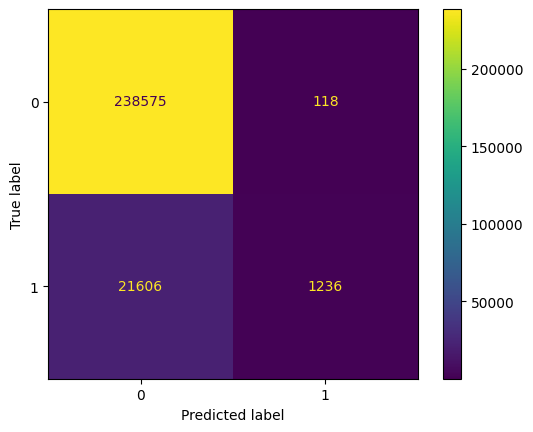

In [37]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()

xgb_model = train_model(data_pipline, xgb_classifier, X_train, y_train)

evaluate_model(xgb_model, X_test, y_test)

In [30]:
y_test.nunique()

2

####2. Naive-Bayes Classifier

Model trained: GaussianNB()
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85    238693
           1       0.15      0.38      0.21     22842

    accuracy                           0.75    261535
   macro avg       0.54      0.58      0.53    261535
weighted avg       0.86      0.75      0.80    261535



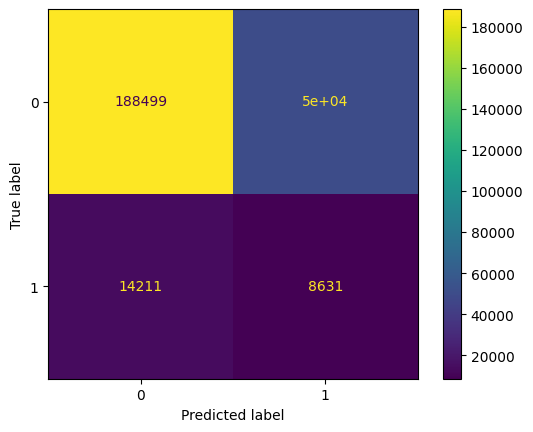

In [45]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()

nb_model = train_model(data_pipline, nb_classifier, X_train, y_train)

evaluate_model(nb_model, X_test, y_test)

In [46]:
demoDf = s3_utils.load_dataframe(AWS_S3_DATA_DIRECTORY_RAW, DEMO_DATASET)

Loading 's3://loan-default-prediction/dataset-3/raw/merged_demo_data.csv' file as dataframe.


In [47]:
demoDf.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,106028.000000,106028.000000,106028.000000,1.060280e+05,1.060280e+05,106019.000000,1.059290e+05,106028.000000,106028.000000,106028.000000,...,352.000000,106028.000000,106028.000000,82932.000000,64157.000000,64157.000000,64157.000000,64157.000000,64157.000000,64157.000000
mean,278690.437017,0.087241,0.407939,1.755077e+05,5.887284e+05,27050.510578,5.288014e+05,0.020754,-16298.106029,67541.787896,...,0.776055,-881.963095,296.750358,15.973774,342233.582633,13383.215066,33451.159951,77380.754337,83040.932681,0.331250
std,102722.085471,0.282189,0.719699,5.173640e+05,3.850424e+05,13970.394017,3.533454e+05,0.013298,4335.258546,144369.909158,...,0.101170,783.591433,1463.939059,14.490111,88877.691039,71399.974046,106409.167188,150209.043392,153984.229014,0.470666
min,100009.000000,0.000000,0.000000,2.655000e+04,4.500000e+04,2052.000000,4.050000e+04,0.000290,-25201.000000,-17912.000000,...,0.424419,-2922.000000,-1.000000,0.000000,-2920.000000,-2891.000000,-2797.000000,-2878.000000,-2870.000000,0.000000
25%,189699.750000,0.000000,0.000000,1.125000e+05,2.701260e+05,16839.000000,2.385000e+05,0.010032,-19944.000000,-2836.000000,...,0.715645,-1316.000000,-1.000000,6.000000,365243.000000,-1626.000000,-1240.000000,-1312.000000,-1266.000000,0.000000
50%,279090.500000,0.000000,0.000000,1.575000e+05,5.084955e+05,24930.000000,4.500000e+05,0.018850,-16013.500000,-1285.000000,...,0.835095,-584.000000,4.000000,12.000000,365243.000000,-826.000000,-357.000000,-535.000000,-494.000000,0.000000
75%,367611.500000,0.000000,1.000000,2.115000e+05,8.086500e+05,34578.000000,6.795000e+05,0.028663,-12729.000000,-296.000000,...,0.852537,-273.000000,84.000000,24.000000,365243.000000,-409.000000,135.000000,-74.000000,-40.000000,1.000000
max,456244.000000,1.000000,19.000000,1.170000e+08,3.956274e+06,197230.500000,3.825000e+06,0.072508,-7680.000000,365243.000000,...,1.000000,-2.000000,74625.000000,84.000000,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [48]:
X_demo, y_demo = demoDf.drop("TARGET", axis=1), demoDf["TARGET"]

In [49]:
print(X_demo.shape, y_demo.shape)

(106028, 157) (106028,)


Classification report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85     96778
           1       0.14      0.37      0.20      9250

    accuracy                           0.75    106028
   macro avg       0.53      0.58      0.53    106028
weighted avg       0.86      0.75      0.79    106028



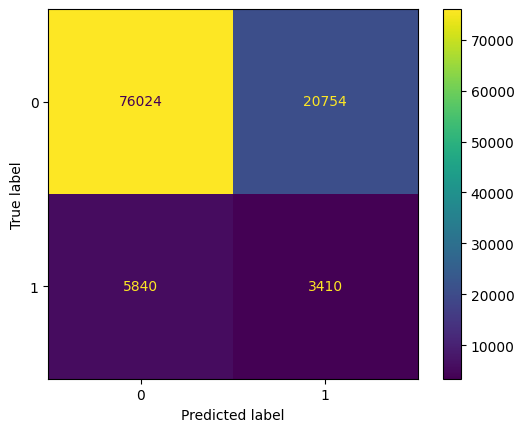

In [51]:
evaluate_model(nb_model, X_demo, y_demo)

Classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     96778
           1       0.93      0.05      0.10      9250

    accuracy                           0.92    106028
   macro avg       0.92      0.53      0.53    106028
weighted avg       0.92      0.92      0.88    106028



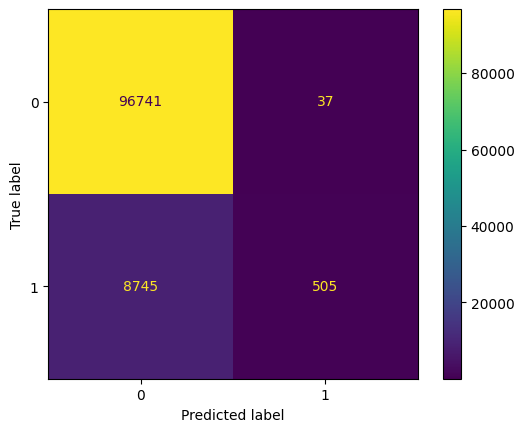

In [52]:
evaluate_model(xgb_model, X_demo, y_demo)

####3. RandomForest Classifier Model

Model trained: RandomForestClassifier(n_jobs=-1)
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97    238693
           1       1.00      0.43      0.60     22842

    accuracy                           0.95    261535
   macro avg       0.97      0.71      0.78    261535
weighted avg       0.95      0.95      0.94    261535



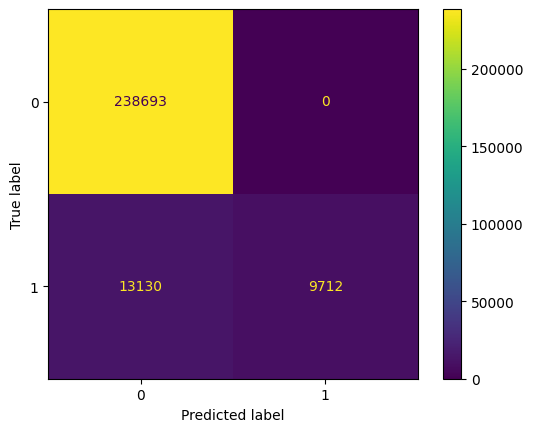

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     96778
           1       1.00      0.43      0.60      9250

    accuracy                           0.95    106028
   macro avg       0.97      0.71      0.79    106028
weighted avg       0.95      0.95      0.94    106028



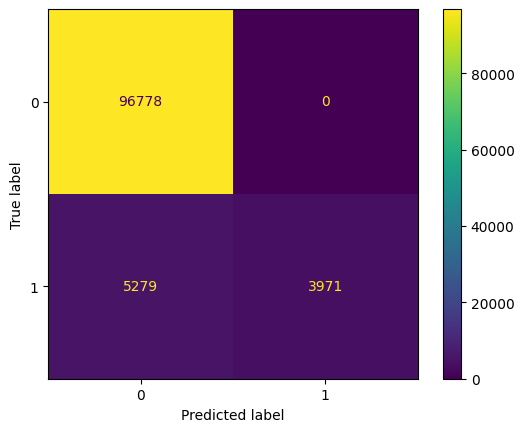

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_jobs=-1)

rf_model = train_model(data_pipline, rf_classifier, X_train, y_train)

evaluate_model(rf_model, X_test, y_test)

evaluate_model(rf_model, X_demo, y_demo)

In [58]:
rf_model.predict_proba(X_demo)[:, 1]

array([0.02, 0.06, 0.07, ..., 0.01, 0.08, 0.09])

####4. Logistic Regression

Model trained: LogisticRegression(max_iter=3000)
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95    238693
           1       0.60      0.00      0.00     22842

    accuracy                           0.91    261535
   macro avg       0.76      0.50      0.48    261535
weighted avg       0.89      0.91      0.87    261535



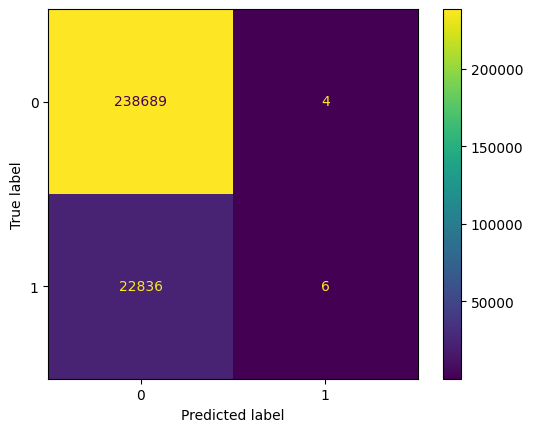

Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     96778
           1       0.67      0.00      0.00      9250

    accuracy                           0.91    106028
   macro avg       0.79      0.50      0.48    106028
weighted avg       0.89      0.91      0.87    106028



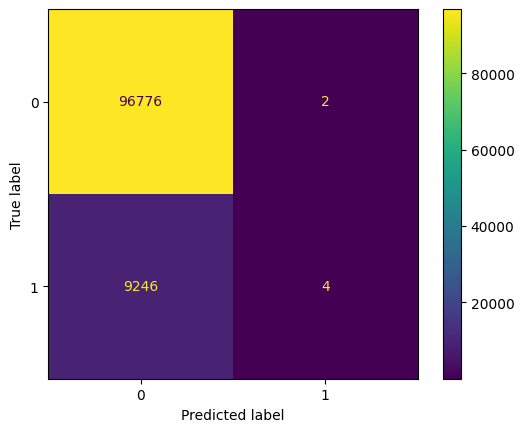

In [54]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=3000)

lr_model = train_model(data_pipline, log_reg, X_train, y_train)

evaluate_model(lr_model, X_test, y_test)

evaluate_model(lr_model, X_demo, y_demo)

####5. KNN Classifier

c:\Users\cr-admin\repos\loan-default-prediction\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model trained: KNeighborsClassifier(n_jobs=-1)
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96    238693
           1       0.58      0.20      0.29     22842

    accuracy                           0.92    261535
   macro avg       0.75      0.59      0.62    261535
weighted avg       0.90      0.92      0.90    261535



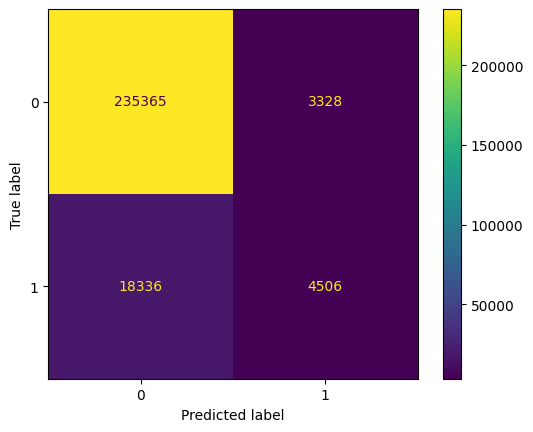

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     96778
           1       0.58      0.20      0.30      9250

    accuracy                           0.92    106028
   macro avg       0.75      0.59      0.63    106028
weighted avg       0.90      0.92      0.90    106028



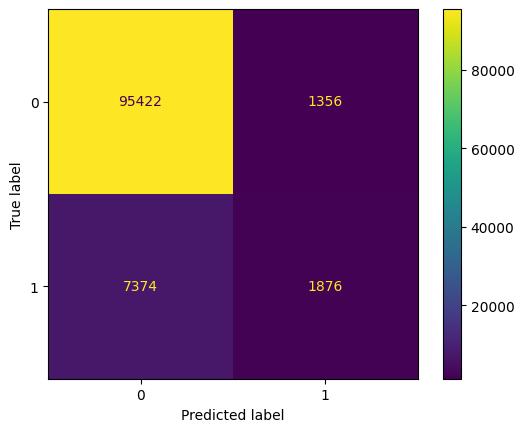

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_jobs=-1)

knn_model = train_model(data_pipline, knn_classifier, X_train, y_train)

evaluate_model(knn_model, X_test, y_test)

evaluate_model(knn_model, X_demo, y_demo)

## FORMATTING PREDICTIONS

In [5]:
from utils.s3_Functions import S3Utils
from utils.load_EnvVars import (
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY,
    AWS_S3_BUCKET,
    AWS_S3_DATA_DIRECTORY,
    AWS_S3_DATA_DIRECTORY_MODELS,
    MODEL_NAME,
    MODEL_VERSION,
)

In [6]:
# Create an instance of S3Utils class to access various methods
s3_utils = S3Utils(
    AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_S3_BUCKET, AWS_S3_DATA_DIRECTORY
)

In [7]:
# Define a singleton model wrapper
class ModelWrapper:
    def __init__(self, dirPath: str, fileName: str):
        """Load model from S3"""

        self.model = s3_utils.load_pickle(dirPath, fileName, compressed=True)

    def predict(self, data):
        return self.model.predict(data)
    
    def predict_proba(self, data):
        return self.model.predict_proba(data)

In [8]:
# Load the model
model_wrapper = ModelWrapper(AWS_S3_DATA_DIRECTORY_MODELS, f"{MODEL_NAME}_{MODEL_VERSION}.pkl")

Loading pickle file from 's3://loan-default-prediction/dataset-3/models/rf_model_v1.0.pkl.gz'


Loading: 100%|██████████| 177M/177M [00:21<00:00, 8.69MB/s]    


In [9]:
import pandas as pd
demo_dataframe = pd.read_csv(r"C:\\Users\\cr-admin\\Desktop\\demo_data_sample1.csv")
demo_dataframe.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,154592,0,Cash loans,M,Y,Y,1,202500.0,576000.0,45639.0,...,Consumer electronics,24.0,middle,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
1,392304,0,Cash loans,F,Y,Y,0,382657.5,1125000.0,33025.5,...,Clothing,12.0,middle,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN
2,422926,0,Cash loans,M,N,Y,1,135000.0,269550.0,24853.5,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-147.0,183.0,365243.0,365243.0,1.0
3,252171,0,Cash loans,F,N,Y,0,144000.0,283500.0,12618.0,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
4,425552,0,Cash loans,F,N,Y,1,54000.0,291384.0,20722.5,...,Consumer electronics,12.0,high,POS household with interest,365243.0,-893.0,-563.0,-563.0,-558.0,0.0


In [10]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

def evaluate_model(model, X_test, y_test):
    """Function to evaluate the model on test data and print model metrics."""

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Print Classification report
    print("Classification report:\n", classification_report(y_test, y_pred))

    # Display COnfusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.show()

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        95
           1       1.00      0.25      0.40         4

    accuracy                           0.97        99
   macro avg       0.98      0.62      0.69        99
weighted avg       0.97      0.97      0.96        99



NameError: name 'plt' is not defined

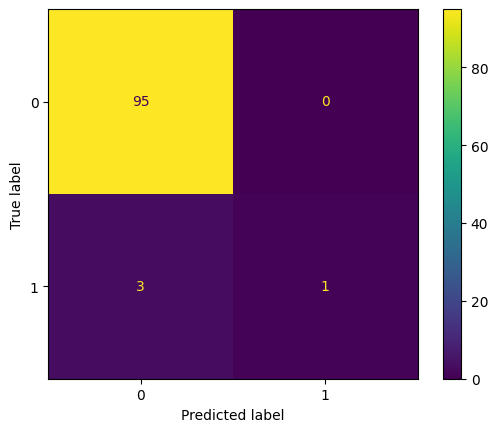

In [11]:
evaluate_model(model_wrapper, demo_dataframe.drop("TARGET", axis=1), demo_dataframe["TARGET"] )

In [11]:
predictions = model_wrapper.predict(demo_dataframe)
probabilities = model_wrapper.predict_proba(demo_dataframe)

In [13]:
results = pd.DataFrame({
                "SK_ID_CURR": demo_dataframe.iloc[:, 0],
                "Prediction Class": predictions,
                "Probability 0": probabilities[:, 0],
                "Probability 1": probabilities[:, 1]
            })

In [15]:
print(results.to_dict(orient='records'))

[{'SK_ID_CURR': 396168, 'Prediction Class': 0, 'Probability 0': 0.96, 'Probability 1': 0.04}, {'SK_ID_CURR': 159899, 'Prediction Class': 0, 'Probability 0': 0.98, 'Probability 1': 0.02}, {'SK_ID_CURR': 230426, 'Prediction Class': 0, 'Probability 0': 0.86, 'Probability 1': 0.14}, {'SK_ID_CURR': 201258, 'Prediction Class': 0, 'Probability 0': 0.97, 'Probability 1': 0.03}, {'SK_ID_CURR': 189746, 'Prediction Class': 0, 'Probability 0': 0.91, 'Probability 1': 0.09}, {'SK_ID_CURR': 252179, 'Prediction Class': 0, 'Probability 0': 0.95, 'Probability 1': 0.05}, {'SK_ID_CURR': 347559, 'Prediction Class': 0, 'Probability 0': 0.97, 'Probability 1': 0.03}, {'SK_ID_CURR': 202673, 'Prediction Class': 0, 'Probability 0': 1.0, 'Probability 1': 0.0}, {'SK_ID_CURR': 192269, 'Prediction Class': 0, 'Probability 0': 0.89, 'Probability 1': 0.11}, {'SK_ID_CURR': 371888, 'Prediction Class': 0, 'Probability 0': 1.0, 'Probability 1': 0.0}, {'SK_ID_CURR': 115813, 'Prediction Class': 0, 'Probability 0': 0.94, 'Pro

In [19]:
response = results.to_dict(orient='records')
print(type(response))

<class 'list'>


In [20]:
import json

response_results = pd.DataFrame.from_dict(response)
print(response_results)

    SK_ID_CURR  Prediction Class  Probability 0  Probability 1
0       396168                 0           0.96           0.04
1       159899                 0           0.98           0.02
2       230426                 0           0.86           0.14
3       201258                 0           0.97           0.03
4       189746                 0           0.91           0.09
..         ...               ...            ...            ...
94      135606                 0           0.97           0.03
95      327382                 0           0.93           0.07
96      342114                 0           0.97           0.03
97      136611                 0           0.98           0.02
98      291054                 0           0.94           0.06

[99 rows x 4 columns]
